# Jupyter intro

### Useful shortcuts:
- Shift + Tab - function tooltip
- Shift + Tab + Tab - more detailed function info
- Tab - autocomplete list
- Shift + Enter - run cell

# Pandas intro

### Load all needed libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn # for prettier plots, probably need to install it => conda install seaborn
%matplotlib inline

c:\python35\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Load datasets
All datasets are complete and unnormalized, there is no holes in them (some data was approximated). Time label represents number of hours from 2005-01-01. 

In [2]:
with open('weather-unnorm.pickle', 'rb') as file:
    weather = pickle.load(file)
    weather = weather['weather']
with open('smog-unnorm.pickle', 'rb') as file:
    smog = pickle.load(file)

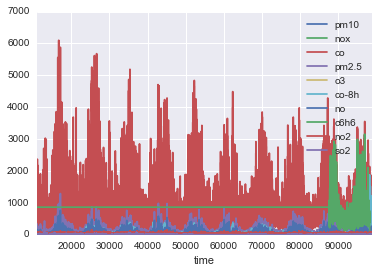

In [3]:
smog['7'].plot(x='time')

### For converting `time` column

In [4]:
def hours_to_date(x):
    base_time = pd.to_datetime('2005-01-01').to_datetime64().astype('int64')
    return pd.to_datetime(base_time // 1000000000 + x * 3600, unit='s')

In [5]:
def date_to_hours(date):
    if type(date) == type(''):
        date = pd.to_datetime(date)
    base_date = pd.to_datetime('2005-01-01').to_datetime64().astype('int64')
    return int((date.to_datetime64().astype('int64') - base_date) // 3600000000000)

# Scikit learn - Regression

In [6]:
from sklearn import linear_model, grid_search

# Actual work
We copy weather and smog data so we don't need to reload them from harddrive if something went wrong.

In [7]:
weather_data = weather.copy()
smog_data = smog['7'].copy()

In [8]:
# Function takes X (training data) and y (training labels) and returns trained model. (Lasso regression)
def create_and_fit_model(X, y):
#     model = linear_model.LinearRegression(n_jobs=8, normalize=True)
    model = linear_model.Lasso(alpha=0.0001, normalize=True)
    model.fit(X, y)
    return model

In [9]:
def plot_fitted_data(model, X, y, begin=0, end=100, station='7', substance='co'):
    prediction = model.predict(X)
    plt.figure(figsize=(16, 9))
    tmp = X[:]
    tmp['target'] = y
    tmp['pred'] = prediction
    tmp = tmp.sort_values(by='time')
    plt.plot(tmp['time'][begin:end], unnormalize_smog(tmp['target'], station, substance)[begin:end])
    plt.plot(tmp['time'][begin:end], unnormalize_smog(tmp['pred'], station, substance)[begin:end])
    plt.show()

In [10]:
def plot_dependency(model, feature_list, top=None):
    if top:
        temp = sorted(zip(model.coef_, feature_list), key=lambda x: abs(x[0]), reverse=True)[:top]
        index = np.arange(len(temp))
        coef = list(map(lambda x: x[0], temp))
        features = list(map(lambda x: x[1], temp))
    else:
        index = np.arange(len(feature_list))
        coef = model.coef_
        features = feature_list
    bar_width = 0.35
    plt.figure(figsize=(16, 9))
    plt.bar(index, coef, bar_width)
    plt.xticks(index + bar_width / 2, features)
    plt.tight_layout()
    plt.show()

In [34]:
def split_data(data, size, rnd=42):
    np.random.seed(rnd)
    dataset = data.reindex(np.random.permutation(data.index))
    length = int(len(data) * size)
    return dataset[:length], dataset[length:]

# Model for PM10 only

In [15]:
subst_data = smog_data[['time', 'pm10']]
subst_data.head()

,time,pm10
0,10920,40.0
1,10921,28.0
2,10922,7.0
3,10923,6.0
4,10924,11.0


## Helper functions

In [16]:
# Changes column with discrete values to hot-encoding representation
def to_hot_encoding(data, column, min_value, max_value):
    temp = data[column]
    for i in range(min_value, max_value + 1):
        data['%s-%d' % (column, i)] = np.array(temp == i, dtype=np.int32)
    return data

In [17]:
# Changes column with discrete values to sin-cos-encoding
def to_sin_cos_encoding(data, column, min_value, max_value):
    temp = data[column]
    data[column + '-sin'] = np.sin((temp - min_value) * np.pi * 2. / (max_value - min_value)) + min_value
    data[column + '-cos'] = np.cos((temp - min_value) * np.pi * 2. / (max_value - min_value)) + min_value
    return data

In [18]:
def split_time_column(data):
    dates = data['time'].apply(hours_to_date)
    data['hour'] = dates.apply(lambda x: x.hour)
    data['weekday'] = dates.apply(lambda x: x.dayofweek)
    data['monthday'] = dates.apply(lambda x: x.day)
    data['weekyear'] = dates.apply(lambda x: x.weekofyear)
    data['dayyear'] = dates.apply(lambda x: x.dayofyear)
    data['month'] = dates.apply(lambda x: x.month)
    return data

In [19]:
subst = split_time_column(subst_data)

c:\python35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\python35\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\python35\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

In [20]:
subst.head()

,time,pm10,hour,weekday,monthday,weekyear,dayyear,month
0,10920,40.0,0,5,1,13,91,4
1,10921,28.0,1,5,1,13,91,4
2,10922,7.0,2,5,1,13,91,4
3,10923,6.0,3,5,1,13,91,4
4,10924,11.0,4,5,1,13,91,4


## Add weather features
We are trying to predict the next day PM10 value using value from previous day + weather prediction for next day.

In [22]:
temp_weather = weather_data.copy()
temp_weather['time'] -= 24 # shift by 24h to make it future values

In [27]:
subst_weather = pd.merge(subst, temp_weather, on='time') # Merge two datasets by 'time'
subst_weather = subst_weather[subst_weather['time'] >= 57500] # select all after

In [28]:
target_subst = 'pm10'
subst_weather['target'] = subst_weather[target_subst].shift(-24, axis=0) # shift target label by 24h

subst_weather = subst_weather[subst_weather['time'] >= 57500][:40000]
subst_weather.head()

,time,pm10,hour,weekday,monthday,weekyear,dayyear,month,wind-direction,humidity,pressure,wind-speed,rain,temperature,target
64,57500,25.0,20,6,24,29,205,7,230.0,92.13,982.80,1.240,9.93,14.31,48.0
65,57501,30.0,21,6,24,29,205,7,236.0,92.16,983.15,1.220,10.03,14.10,46.0
66,57502,31.0,22,6,24,29,205,7,242.0,91.65,983.44,1.200,10.03,14.07,43.0
67,57503,29.0,23,6,24,29,205,7,261.0,91.40,983.63,0.910,10.03,14.17,42.0
68,57504,41.0,0,0,25,30,206,7,264.0,91.82,983.89,0.965,10.03,14.23,41.0


In [29]:
subst_weather = subst_weather.drop('time', 1) # drop 'time' label, not needed

In [30]:
subst_weather[:72:24]

,pm10,hour,weekday,monthday,weekyear,dayyear,month,wind-direction,humidity,pressure,wind-speed,rain,temperature,target
64,25.0,20,6,24,29,205,7,230.0,92.13,982.80,1.240000,9.93,14.31,48.0
88,48.0,20,0,25,30,206,7,216.0,84.75,987.27,0.583333,0.11,18.44,36.0
112,36.0,20,1,26,30,207,7,274.0,90.71,990.71,0.960000,7.85,16.69,22.0


# Model with hot encoded features

In [31]:
# Hot-encode all features
features_to_encode = ['hour', 'weekday', 'monthday', 'weekyear', 'dayyear', 'month']
data_only_hot_encoding = subst_weather.copy()
for feature in features_to_encode:
    min_val, max_val = np.min(subst_weather[feature]), np.max(subst_weather[feature])
    data_only_hot_encoding = to_hot_encoding(data_only_hot_encoding, feature, min_val, max_val)
    data_only_hot_encoding = data_only_hot_encoding.drop(feature, 1)

In [32]:
data_only_hot_encoding.head()

,pm10,wind-direction,humidity,pressure,wind-speed,rain,temperature,target,hour-0,hour-1,...,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
64,25.0,230.0,92.13,982.80,1.240,9.93,14.31,48.0,0,0,...,0,0,0,0,1,0,0,0,0,0
65,30.0,236.0,92.16,983.15,1.220,10.03,14.10,46.0,0,0,...,0,0,0,0,1,0,0,0,0,0
66,31.0,242.0,91.65,983.44,1.200,10.03,14.07,43.0,0,0,...,0,0,0,0,1,0,0,0,0,0
67,29.0,261.0,91.40,983.63,0.910,10.03,14.17,42.0,0,0,...,0,0,0,0,1,0,0,0,0,0
68,41.0,264.0,91.82,983.89,0.965,10.03,14.23,41.0,1,0,...,0,0,0,0,1,0,0,0,0,0


### Split dataset

In [35]:
train_he, valid_test_he = split_data(data_only_hot_encoding, 0.8)
valid_he, test_he = split_data(valid_test_he, 0.5)
print("Train size:", len(train_he))
print("Valid size:", len(valid_he))
print("Test  size:", len(test_he))

Train size: 32000
Valid size: 4000
Test  size: 4000


### List some features

In [36]:
features_he = list(data_only_hot_encoding.columns)
features_he.remove('target')
print(features_he[::10])

['pm10', 'hour-3', 'hour-13', 'hour-23', 'monthday-3', 'monthday-13', 'monthday-23', 'weekyear-2', 'weekyear-12', 'weekyear-22', 'weekyear-32', 'weekyear-42', 'weekyear-52', 'dayyear-9', 'dayyear-19', 'dayyear-29', 'dayyear-39', 'dayyear-49', 'dayyear-59', 'dayyear-69', 'dayyear-79', 'dayyear-89', 'dayyear-99', 'dayyear-109', 'dayyear-119', 'dayyear-129', 'dayyear-139', 'dayyear-149', 'dayyear-159', 'dayyear-169', 'dayyear-179', 'dayyear-189', 'dayyear-199', 'dayyear-209', 'dayyear-219', 'dayyear-229', 'dayyear-239', 'dayyear-249', 'dayyear-259', 'dayyear-269', 'dayyear-279', 'dayyear-289', 'dayyear-299', 'dayyear-309', 'dayyear-319', 'dayyear-329', 'dayyear-339', 'dayyear-349', 'dayyear-359', 'month-3']


### Make model

In [38]:
model_hot_encoding = create_and_fit_model(train_he[features_he], train_he['target'])

### Evaluate model on validation set

In [39]:
model_hot_encoding_score = model_hot_encoding.score(valid_he[features_he], valid_he['target'])
print('pm10:', model_hot_encoding_score)

pm10: 0.454975758834


# Model with sin-cos features

In [40]:
# Encode features as sin-cos
features_to_encode = ['hour', 'weekday', 'monthday', 'weekyear', 'dayyear', 'month']
data_only_sincos = subst_weather.copy()
for feature in features_to_encode:
    min_val, max_val = np.min(subst_weather[feature]), np.max(subst_weather[feature])
    data_only_sincos = to_sin_cos_encoding(data_only_sincos, feature, min_val, max_val)
    data_only_sincos = data_only_sincos.drop(feature, 1)

In [41]:
data_only_sincos.head()

,pm10,wind-direction,humidity,pressure,wind-speed,rain,temperature,target,hour-sin,hour-cos,weekday-sin,weekday-cos,monthday-sin,monthday-cos,weekyear-sin,weekyear-cos,dayyear-sin,dayyear-cos,month-sin,month-cos
64,25.0,230.0,92.13,982.80,1.240,9.93,14.31,48.0,-7.308360e-01,0.682553,-2.449294e-16,1.0,0.005478,1.104528,0.760684,0.029058,0.638286,0.067711,0.718267,0.040507
65,30.0,236.0,92.16,983.15,1.220,10.03,14.10,46.0,-5.195840e-01,0.854419,-2.449294e-16,1.0,0.005478,1.104528,0.760684,0.029058,0.638286,0.067711,0.718267,0.040507
66,31.0,242.0,91.65,983.44,1.200,10.03,14.07,43.0,-2.697968e-01,0.962917,-2.449294e-16,1.0,0.005478,1.104528,0.760684,0.029058,0.638286,0.067711,0.718267,0.040507
67,29.0,261.0,91.40,983.63,0.910,10.03,14.17,42.0,-2.449294e-16,1.000000,-2.449294e-16,1.0,0.005478,1.104528,0.760684,0.029058,0.638286,0.067711,0.718267,0.040507
68,41.0,264.0,91.82,983.89,0.965,10.03,14.23,41.0,0.000000e+00,1.000000,0.000000e+00,1.0,0.048943,1.309017,0.645395,0.064984,0.622292,0.074075,0.718267,0.040507


### Split dataset

In [42]:
train_sc, valid_test_sc = split_data(data_only_sincos, 0.8)
valid_sc, test_sc = split_data(valid_test_sc, 0.5)
print("Train size:", len(train_sc))
print("Valid size:", len(valid_sc))
print("Test  size:", len(test_sc))

Train size: 32000
Valid size: 4000
Test  size: 4000


### List all features

In [43]:
features_sc = list(data_only_sincos.columns)
features_sc.remove('target')
print(features_sc)

['pm10', 'wind-direction', 'humidity', 'pressure', 'wind-speed', 'rain', 'temperature', 'hour-sin', 'hour-cos', 'weekday-sin', 'weekday-cos', 'monthday-sin', 'monthday-cos', 'weekyear-sin', 'weekyear-cos', 'dayyear-sin', 'dayyear-cos', 'month-sin', 'month-cos']


### Make model

In [44]:
model_sincos = create_and_fit_model(train_sc[features_sc], train_sc['target'])

### Evaluate model on validation set

In [45]:
model_sincos_score = model_sincos.score(valid_sc[features_sc], valid_sc['target'])
print('pm10:', model_sincos_score)

pm10: 0.402324004476


# Model with sin-cos and hot-encoded features

In [47]:
features_to_encode = ['hour', 'weekday', 'monthday', 'weekyear', 'dayyear', 'month']
data_he_sc = subst_weather.copy()
for feature in features_to_encode:
    min_val, max_val = np.min(subst_weather[feature]), np.max(subst_weather[feature])
    data_he_sc = to_sin_cos_encoding(data_he_sc, feature, min_val, max_val)
    data_he_sc = to_hot_encoding(data_he_sc, feature, min_val, max_val)
    data_he_sc = data_he_sc.drop(feature, 1)

In [48]:
data_he_sc.head()

,pm10,wind-direction,humidity,pressure,wind-speed,rain,temperature,target,hour-sin,hour-cos,...,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
64,25.0,230.0,92.13,982.80,1.240,9.93,14.31,48.0,-7.308360e-01,0.682553,...,0,0,0,0,1,0,0,0,0,0
65,30.0,236.0,92.16,983.15,1.220,10.03,14.10,46.0,-5.195840e-01,0.854419,...,0,0,0,0,1,0,0,0,0,0
66,31.0,242.0,91.65,983.44,1.200,10.03,14.07,43.0,-2.697968e-01,0.962917,...,0,0,0,0,1,0,0,0,0,0
67,29.0,261.0,91.40,983.63,0.910,10.03,14.17,42.0,-2.449294e-16,1.000000,...,0,0,0,0,1,0,0,0,0,0
68,41.0,264.0,91.82,983.89,0.965,10.03,14.23,41.0,0.000000e+00,1.000000,...,0,0,0,0,1,0,0,0,0,0


### Split dataset

In [49]:
train_he_sc, valid_test_he_sc = split_data(data_he_sc, 0.8)
valid_he_sc, test_he_sc = split_data(valid_test_he_sc, 0.5)
print("Train size:", len(train_he_sc))
print("Valid size:", len(valid_he_sc))
print("Test  size:", len(test_he_sc))

Train size: 32000
Valid size: 4000
Test  size: 4000


### List all features

In [50]:
features_he_sc = list(data_he_sc.columns)
features_he_sc.remove('target')
# print(features_he_sc)

### Make model

In [51]:
model_he_sc = create_and_fit_model(train_he_sc[features_he_sc], train_he_sc['target'])

### Evaluate model on validation set

In [52]:
model_he_sc_score = model_he_sc.score(valid_he_sc[features_he_sc], valid_he_sc['target'])
print('pm10:', model_he_sc_score)

pm10: 0.45502818674


## Feature weights

In [54]:
# Plot top=20 features that have the highest absolute values
# plot_dependency(model_hot_encoding, features_he, top=20)

In [55]:
# for f, c in zip(features_he, model_hot_encoding.coef_):
#     print('%-20s: %10.6f' % (f, c))

## Score function

In [56]:
# Score used by sklearn regression models
def calc_score(predicted, target):
    v = np.sum((target - predicted)**2)
    u = np.sum((target - np.mean(target))**2)
    return 1 - v**2 / u**2

# Uniform-random model

In [59]:
train, valid_test = split_data(subst_weather, 0.8)
valid, test = split_data(valid_test, 0.5)
print('Train size:', len(train))
print('Valid size:', len(valid))
print('Test size: ', len(test))

Train size: 32000
Valid size: 4000
Test size:  4000


In [60]:
pm10_min, pm10_max = train[target_subst].min(), train[target_subst].max()
random_score = 0.
for _ in range(100):
    random_score += calc_score(np.random.random(len(valid)) * (pm10_max - pm10_min) + pm10_min, valid['target'])
random_score /= 100.
full_random_model_score = random_score
print('Random model score:', random_score)

Random model score: -1422.23620785


# Normal-random model

In [61]:
train, valid_test = split_data(subst_weather, 0.8)
valid, test = split_data(valid_test, 0.5)
print('Train size:', len(train))
print('Valid size:', len(valid))
print('Test size: ', len(test))

Train size: 32000
Valid size: 4000
Test size:  4000


In [67]:
pm10_mean, pm10_std = train[target_subst].mean(), train[target_subst].std()
random_score = 0.
for _ in range(100):
    random_prediction = np.random.normal(pm10_mean, pm10_std, len(valid))
    random_score += calc_score(random_prediction, valid['target'])
random_score /= 100.
normal_random_model_score = random_score
print('Avg. normal-random model score:', random_score)

Avg. normal-random model score: -3.04870243194


# Previous-day + normal-random

In [72]:
pm10_std = train[target_subst].std()
random_score = 0.
for _ in range(100):
    random_prediction = valid[target_subst] + np.random.normal(scale=pm10_std, size=len(valid))
    random_score += calc_score(random_prediction, valid['target'])
random_score /= 100.
prev_normal_model_score = random_score
print('Avg. previous-day + normal-random model score:', prev_normal_model_score)

Avg. previous-day + normal-random model score: -2.94945851049


# Previous day model

In [73]:
train, valid_test = split_data(subst_weather, 0.8)
valid, test = split_data(valid_test, 0.5)
print('Train size:', len(train))
print('Valid size:', len(valid))
print('Test size: ', len(test))

Train size: 32000
Valid size: 4000
Test size:  4000


In [74]:
previous_day_model_score = calc_score(valid[target_subst], valid['target'])
print('Previous-day model score:', previous_day_model_score)

Previous-day model score: 0.0391860638329


# Previous day regression model

In [75]:
naive_model = create_and_fit_model(np.array(train[target_subst]).reshape((-1, 1)), np.array(train['target']))
naive_prev_model_score = naive_model.score(np.array(valid[target_subst]).reshape((-1, 1)), valid['target'])
print('Naive previous day model score:', naive_prev_model_score)

Naive previous day model score: 0.253974642049


# Comparison

In [76]:
print('Only hot encoding:               ', model_hot_encoding_score)
print('Only sin-cos encoding:           ', model_sincos_score)
print('Both (hot encoding and sin-cos): ', model_he_sc_score)
print('Full random model:               ', full_random_model_score)
print('Normal random model:             ', normal_random_model_score)
print('Previous day model:              ', previous_day_model_score)
print('Previous day + normal model:     ', prev_normal_model_score)
print('Naive previous day model score:  ', naive_prev_model_score)

Only hot encoding:                0.454975758834
Only sin-cos encoding:            0.402324004476
Both (hot encoding and sin-cos):  0.45502818674
Full random model:                -1422.23620785
Normal random model:              -3.04870243194
Previous day model:               0.0391860638329
Previous day + normal model:      -2.94945851049
Naive previous day model score:   0.253974642049


# Some kind of score

In [78]:
from sklearn import metrics

In [79]:
pm10_limit = 40.

In [80]:
names = ['he', 'sc', 'both']
valids = {'he': valid_he, 'sc': valid_sc, 'both': valid_he_sc}
models = {'he': model_hot_encoding, 'sc': model_sincos, 'both': model_he_sc}
sel_features = {'he': features_he, 'sc': features_sc, 'both': features_he_sc}

In [81]:
names_for_model = {'he': 'Hot-encoding:          ', 'sc': 'Sin-cos encoding:      ', 'both': 'Both (hot-enc/sin-cos):'}
for n in names:
    vk = valids[n]['target'] >= pm10_limit
    mk = models[n].predict(valids[n][sel_features[n]]) >= pm10_limit
    print(names_for_model[n], metrics.f1_score(vk, mk))
vk = valid['target'] >= pm10_limit
mk = valid[target_subst] >= pm10_limit
print('Previous day:          ', metrics.f1_score(vk, mk))
# -----
mk = (np.random.random(len(valid)) * (pm10_max - pm10_min) + pm10_min) >= pm10_limit
print('Uniform-random:        ', metrics.f1_score(vk, mk))
# -----
mk = (np.random.normal(pm10_mean, pm10_std, len(valid))) >= pm10_limit
print('Normal-random:         ', metrics.f1_score(vk, mk))
# -----
mk = (valid[target_subst] + np.random.normal(size=len(valid))) >= pm10_limit
print('Previous day + normal: ', metrics.f1_score(vk, mk))
# -----
mk = naive_model.predict(np.array(valid[target_subst]).reshape((-1, 1))) >= pm10_limit
print('Naive prev. day model: ', metrics.f1_score(vk, mk))
# -----
mk = np.ones(len(valid))
print('Always 1:              ', metrics.f1_score(vk, mk))

Hot-encoding:           0.751396648045
Sin-cos encoding:       0.75050893463
Both (hot-enc/sin-cos): 0.752096924511
Previous day:           0.710588235294
Uniform-random:         0.631988676575
Normal-random:          0.539986010725
Previous day + normal:  0.709354413702
Naive prev. day model:  0.722431772798
Always 1:               0.645674623328


In [82]:
names_for_model = {'he': 'Hot-encoding:          ', 'sc': 'Sin-cos encoding:      ', 'both': 'Both (hot-enc/sin-cos):'}
for n in names:
    vk = valids[n]['target'] >= pm10_limit
    mk = models[n].predict(valids[n][sel_features[n]]) >= pm10_limit
    print(names_for_model[n], metrics.f1_score(vk, mk))
vk = valid['target'] >= pm10_limit
mk = valid[target_subst] >= pm10_limit
print('Previous day:          ', np.sum(vk == mk) / len(vk))
# -----
mk = (np.random.random(len(valid)) * (pm10_max - pm10_min) + pm10_min) >= pm10_limit
print('Uniform-random:        ', np.sum(vk == mk) / len(vk))
# -----
mk = (np.random.normal(pm10_mean, pm10_std, len(valid))) >= pm10_limit
print('Normal-random:         ', np.sum(vk == mk) / len(vk))
# -----
mk = (valid[target_subst] + np.random.normal(size=len(valid))) >= pm10_limit
print('Previous day + normal: ', np.sum(vk == mk) / len(vk))
# -----
mk = naive_model.predict(np.array(valid[target_subst]).reshape((-1, 1))) >= pm10_limit
print('Naive prev. day model: ', np.sum(vk == mk) / len(vk))
# -----
mk = np.ones(len(valid))
print('Always 1:              ', np.sum(vk == mk) / len(vk))

Hot-encoding:           0.751396648045
Sin-cos encoding:       0.75050893463
Both (hot-enc/sin-cos): 0.752096924511
Previous day:           0.72325
Uniform-random:         0.48275
Normal-random:          0.49625
Previous day + normal:  0.72425
Naive prev. day model:  0.68725
Always 1:               0.47675


# Check weights on each day in hot-encoded model

In [85]:
vals = []
for f, c in zip(features_he, model_hot_encoding.coef_):
    if f.startswith('dayyear'):
        vals.append(c)

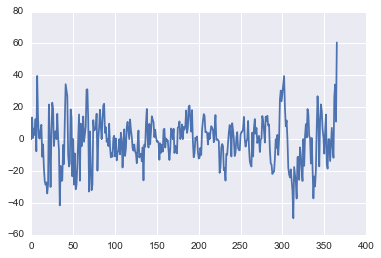

In [86]:
plt.plot(vals)
plt.show()

# Export models

In [87]:
# all_models = {
#     'hot_encoding': {
#         'model': model_hot_encoding,
#         'features': features_he
#     }, 
#     'sin_cos_encoding': {
#         'model': model_sincos,
#         'features': features_sc
#     }, 
#     'both': {
#         'model': model_he_sc,
#         'features': features_he_sc
#     },
#     'prev_day': {
#         'model': naive_model,
#         'features': [target_subst]
#     }
# }
# with open('more_models.pickle', 'wb') as save:
#     pickle.dump(all_models, save, protocol=pickle.HIGHEST_PROTOCOL)